In [476]:
import pandas as pd
import numpy as np

### Importing and processing the data for analysis

In [477]:
data = pd.read_excel('Datasheet - Conversions - Data Analysis.xlsx')

In [478]:
data.head()

,Customer ID,Registration Date,Source,First Purchase Date,Date Second Purchase,Last Purchase,Total Orders
0,3024.0,2019-11-07,Email,NaN,NaT,NaN,NaN
1,3040.0,2019-11-10,Email,NaN,NaT,NaN,NaN
2,3041.0,2019-11-10,Email,NaN,NaT,NaN,NaN
3,3042.0,2019-11-10,Email,NaN,NaT,NaN,NaN
4,3049.0,2019-11-12,Email,NaN,NaT,NaN,NaN


### Checking data types for consistency

In [479]:
data.dtypes

Customer ID                    float64
Registration Date       datetime64[ns]
Source                          object
First Purchase Date             object
Date Second Purchase    datetime64[ns]
Last Purchase                   object
Total Orders                   float64
dtype: object

Changing the dtypes to relevant formats

In [480]:
## remove weird missing entry
data['Last Purchase'].loc[2286] = np.nan

/var/folders/qy/cs03qq_s3m771flt192p28hm0000gn/T/ipykernel_70538/2129289720.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Last Purchase'].loc[2286] = np.nan
/var/folders/qy/cs03qq_s3m771flt192p28hm0000gn/T/ipykernel_70538/2129289

In [481]:
data['Source'] = data['Source'].astype('str')
data['First Purchase Date'] = data['First Purchase Date'].astype('datetime64[ns]')
data['Last Purchase'] = data['Last Purchase'].astype('datetime64[ns]')

In [482]:
data.head()

,Customer ID,Registration Date,Source,First Purchase Date,Date Second Purchase,Last Purchase,Total Orders
0,3024.0,2019-11-07,Email,NaT,NaT,NaT,NaN
1,3040.0,2019-11-10,Email,NaT,NaT,NaT,NaN
2,3041.0,2019-11-10,Email,NaT,NaT,NaT,NaN
3,3042.0,2019-11-10,Email,NaT,NaT,NaT,NaN
4,3049.0,2019-11-12,Email,NaT,NaT,NaT,NaN


### Analysis of different cohorts

##### Total order averages over the entire year

In [483]:
## copying the original data for manipulation (remove missing data)
data_mean = data.copy(deep=True)
data_mean = data_mean.dropna()

## calculating the table of average total orders for each source
data_mean[['Total Orders', 'Source']].groupby('Source').mean()

,Total Orders
Source,
Email,4.677419
Facebook,4.478070
Google / Other Search,3.883333
Instagram,3.352941
Pinterest,2.000000
Referral,4.554054
nan,5.200000


From the table above, we can see that from all the channels, Email, Referral, and Facebook drive the most conversion (and possibly traffic). This may be due to the nature of the wholesale market where the demand side is composed of retail businesses or similar, whose employees and owners usually operate in these spaces. Interesting observation is Instagram and Pinterest, which could signify other cohorts within the demand side, such as consumers.

Further data on traffic from source, click-through rates and user journey from channel to website would be nice, as it would allow me to know more about how these channels bring in customers and what the customers are like. This will all contribute to tailoring the product/user experience to the customers.

##### Breaking down the total order averages for each month

creating a melted dataframe to stack all purchase occurrences

In [484]:
data_month = data[['Customer ID', 'First Purchase Date', 'Date Second Purchase', 'Last Purchase']].copy(deep=True)

data_month = data_month.rename(columns={'First Purchase Date': 'purchase.1',
                           'Date Second Purchase': 'purchase.2',
                           'Last Purchase': 'purchase.3'})

data_month = data_month.melt('Customer ID', value_name='purchase')

data_month = data_month.drop(columns='variable')

data_month = data_month.set_index('Customer ID')

creating an accessible dictionary of filtered tables by month

In [485]:
data_month = data_month.dropna()

months_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

data_month_dict = {}

for i in months_list:
    data_month_dict[i] = data_month[data_month['purchase'].dt.month == i]


aggregating the data by year and month

In [486]:
data_month = data_month.groupby([data_month['purchase'].dt.year.rename('year'), data_month['purchase'].dt.month.rename('month')]).agg({'count'})
data_month = data_month.drop(index=1970)
data_month

purchase
              count
year month         
2020 1           21
     2           43
     3           18
     4           58
     5          112
     6          195
     7          204
     8          218
     9          249
     10         270
     11         311
     12         114
2021 1          284
     2          378
     3          393
     4          255

visualizing the trend

<Axes: title={'center': 'Purchases over time in 2020'}, xlabel='month', ylabel='No. of purchases'>

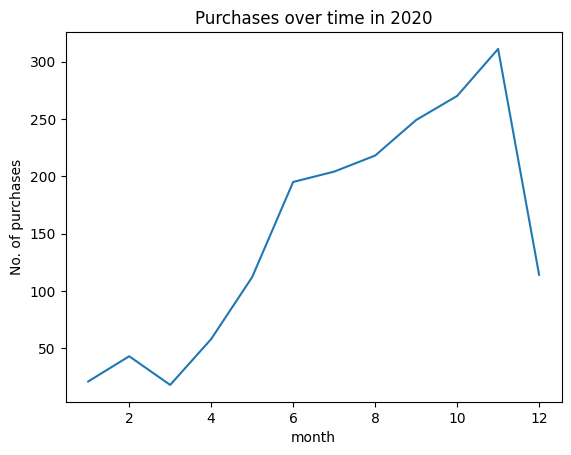

In [487]:
data_month.loc[2020].plot(ylabel='No. of purchases', legend=False, title='Purchases over time in 2020')

<Axes: title={'center': 'Purchases over time in 2021'}, xlabel='month', ylabel='No. of purchases'>

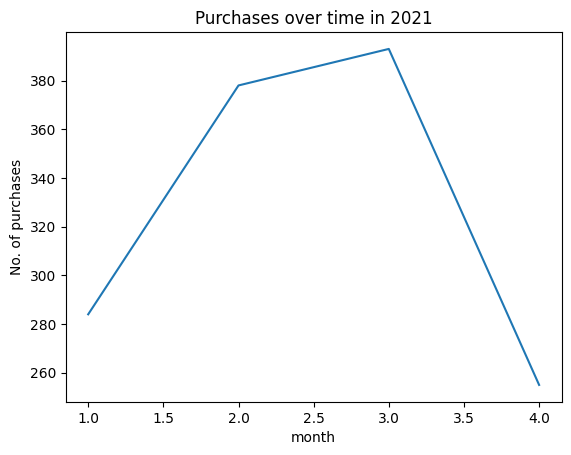

In [488]:
data_month.loc[2021].plot(ylabel='No. of purchases', legend=False, title='Purchases over time in 2021')

Here, you can see that user purchase numbers fluctuate over the course of the year, suggesting some kind of seasonality. A more plausible reasoning is that the wholesale market is not a high frequency marketplace (think Uber, Deliveroo, etc), but a low frequency marketplace (think Healthcare, Insurance, etc.). This means that purchasing frequency will be very needs-based and situational. What we can do is to keep them constantly in the loop with direct-to-consumer marketing campaigns to remind them of our existence and cross-sell as much as possible.

data on cross-purchasing behavior would be good for this.

##### Speed of conversion from clicking through

In [489]:
## get in dt.days the difference between data['Registration Date']
## and data['First Purchase Date']

data_ret = data.copy(deep=True)
data_ret = data_ret.dropna()
data_ret = data_ret.reset_index()
data_ret['days_to_purchase'] = (data_ret['First Purchase Date'] - data_ret['Registration Date']).dt.days
data_ret['days_to_purchase_2'] = (data_ret['Date Second Purchase'] - data_ret['First Purchase Date']).dt.days
data_ret['days_to_purchase_3'] = (data_ret['Last Purchase'] - data_ret['Date Second Purchase']).dt.days
data_ret['first_to_last_purchase'] = (data_ret['Last Purchase'] - data_ret['First Purchase Date']).dt.days

data_ret = data_ret[['Customer ID', 'days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']]

<Axes: >

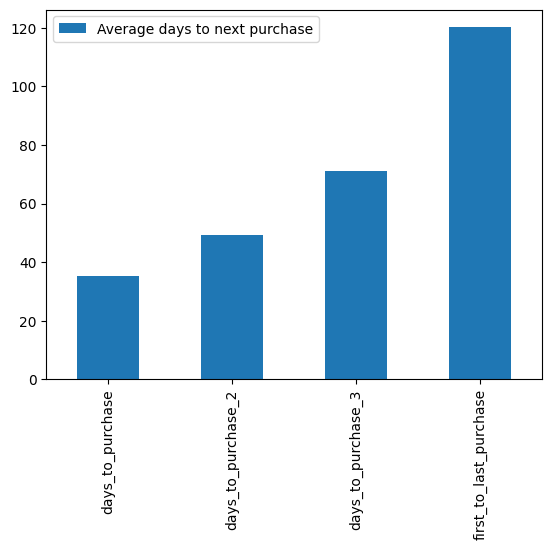

In [492]:
data_ret_mean = pd.DataFrame(data_ret[['days_to_purchase', 'days_to_purchase_2', 'days_to_purchase_3', 'first_to_last_purchase']].mean())

data_ret_mean = data_ret_mean.rename(columns={0: 'Average days to next purchase'})

data_ret_mean.plot.bar()

##### Retention Behavior